# Background Subtraction Using Gaussian Mixture Model

Machine Learning(CS376) Final Report
<br>
이승우(Lee Seungwoo)

## Python Package Imports

이번 보고서에서 사용할 Python 패키지를 불러오는 코드입니다.


This is the code that imports the Python packages for use in your report:


In [ ]:
!pip install imageio
!pip install requests

import time
import random

from IPython.display import display
from IPython.display import clear_output
from IPython.display import Image
import ipywidgets as widgets

import requests
import io
import imageio

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

from scipy.stats import multivariate_normal
import scipy.linalg as la

%matplotlib inline

np.random.seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Introduction

<font color="#6464FF">배경 제거</font>란 정지해 있는 카메라에서 촬영된 영상에서 움직이는 대상인 전경(foreground)을 파악하기 위해 <font color="#6464FF">특정 프레임의 특정 픽셀이 배경에 속하는지 전경에 속하는지 구분함으로써, 전경 픽셀을 강조한 영상을 획득</font>하는 과정입니다. 배경 제거는 물체를 자동으로 감지하는 객체 감지(object detection)의 전처리 과정에 이용되거나, 반대로 여러 프레임에서 알아낸 배경 픽셀을 통해 정지해 있는 배경 이미지를 획득하는 데 이용되기도 합니다.


<font color="#6464FF">Background subtraction</font> is a process used to identify the moving foreground objects in a video captured by a stationary camera. <font color="#6464FF">It determines whether specific pixels in a certain frame belong to the background or the foreground, and obtains an emphasized video of the foreground pixels.</font> Background subtraction is utilized as a preprocessing step in automatic object detection, where objects are detected automatically. Conversely, it can also be used to obtain a static background image by extracting background pixels from multiple frames.

다음은 도로의 CCTV 영상으로, 도로 위에 자동차들이 지나가고 있습니다. 이때 움직이지 않는 도로, 산 등의 주변 지형은 배경이 되고, 움직이는 자동차들은 전경이 됩니다.

In the given CCTV video of a road, there are moving cars on the road while the surrounding terrain, such as the stationary road and mountains, serves as the background. The stationary elements like the road and mountains form the background, while the moving cars constitute the foreground in this scenario.

In [ ]:
before_img = "https://drive.google.com/u/0/uc?export=download&id=1bzHODAblFCa46aTh3vyKeclvWHvFFse0&export=download"
Image(url=before_img)

이 영상에서 배경을 분류하여 제거하고, 전경 픽셀을 흰색으로 표시한 영상은 다음과 같습니다.

The following is the video with the background classified and removed, and the foreground pixels displayed in white.

In [ ]:
after_img = "https://drive.google.com/u/0/uc?export=download&id=1mgHEIWDkoeo5cZVxNaRUO7RNKZbpwCz8&export=download"
Image(url=after_img)

배경 제거를 수행하기 위해서는, 영상에서 특정 프레임의 특정 픽셀이 배경인지 전경인지를 구분해야 하며, 이를 위해 특정 픽셀의 RGB 값의 빈도가 가우시안 혼합 모델(Gaussian Mixture Model, 이하 GMM)의 분포를 따른다고 보고, GMM의 모수를 추정하는 데 사용되는 EM 알고리즘을 이용하여 각 픽셀을 구분하게 됩니다.


To perform background subtraction, it is necessary to determine whether specific pixels in a particular frame of the video belong to the background or the foreground. In order to achieve this, it is assumed that the RGB values of specific pixels follow the distribution of a Gaussian Mixture Model (GMM). The EM (Expectation Maximization) algorithm is used to estimate the parameters of the GMM and classify each pixel accordingly.

이 보고서의 목적은 <font color="#6464FF">GMM을 활용하여 모델링할 수 있는 상황과 이를 EM 알고리즘을 이용해 학습하는 과정 및 결과를 간단한 영상 예제를 통해 소개하는 것</font>으로, 다음과 같은 내용을 다룹니다.

* GMM(Gaussian Mixture Model)과 EM(Expectation Maximization) 알고리즘에 대한 간단한 소개
* GMM을 이용한 배경과 전경 모델링
* EM 알고리즘을 이용한 배경 제거 코드 작성
* 여러 영상에 대해 배경 제거 적용
* 한계 및 해결 방안


<br>


The purpose of this report is <font color="#6464FF">to provide an introduction to the situations that can be modeled using GMM and the process of training them using the EM algorithm, and to demonstrate through simple video examples</font>.
This report covers the following topics:

* A brief introduction to GMM (Gaussian Mixture Model) and the EM (Expectation Maximization) algorithm
* Modeling the background and foreground using GMM
* Implementing code for background subtraction using EM algorithm
* Applying background subtraction to multiple videos
* Analysis of limitations and potential solution

## Gaussian Mixture Model

혼합 모델(Mixture model)이란 주어진 데이터가 하나가 아닌 여러 개의 확률 분포에서 왔다고 생각하는 모델입니다. 특히 <font color="#6464FF">가우시안 혼합 모델(GMM)은 $K$개의 정규분포의 PDF $\mathcal{N}(x|μ_k, Σ_k), k = 1, 2, ..., K$ 중 하나가 $π_k$의 확률로 선택되어 관찰</font>되는 상황을 나타낸 것으로, 수식으로 표현하면 아래와 같습니다. (단, $K$의 값은 사전에 설정되어야 합니다.)


A mixture model is a model that assumes that given data comes from not just one but multiple probability distributions. In particular, the Gaussian Mixture Model (GMM) represents a situation where one of the $K$ Gaussian distributions, denoted as $\mathcal{N}(x|μ_k, Σ_k), k = 1, 2, ..., K$, is selected with a probability $π_k$ and observed. It can be mathematically expressed as follows (where the value of $K$ needs to be predetermined):

$$
p(\boldsymbol x | \boldsymbol \theta) =
\sum_{k=1}^K \pi_k \mathcal{N}(\boldsymbol x|\boldsymbol \mu_k, \boldsymbol \Sigma_k)\,,
\quad \pi_k \geq 0\,,
\quad \sum_{k=1}^K\pi_k = 1
$$

이때, GMM의 모수 \boldsymbol \theta는 개별 정규분포 PDF의 모수와 관찰된 값 $x$가 해당 정규분포에서 나타났을 확률을 포함하므로, $\boldsymbol \theta = \{\mu_k, \Sigma_k, \pi_k\}, k = 1, 2, ..., K$로 표현할 수 있습니다.


Here, the parameters \boldsymbol \theta of the GMM include the parameters of individual Gaussian PDFs and the probability that the observed value $x$ comes from each specific Gaussian distribution. Therefore, $\boldsymbol \theta$ can be represented as ${\mu_k, \Sigma_k, \pi_k}$ for $k = 1, 2, ..., K$.

아래의 그림은 3개의 정규분포 PDF가 혼합된 GMM PDF를 각각의 정규분포의 PDF와 함께 나타낸 것으로, GMM PDF는 다음과 같습니다.


The diagram below represents the GMM PDF that is a mixture of three Gaussian PDFs, along with the individual Gaussian PDFs. The GMM PDF is as follows.



$
p(x|\theta) = 0.5\mathcal{N}(x|-2, 0.5) + 0.2\mathcal{N}(x|1, 2) + 0.3\mathcal{N}(x|4, 1)
$

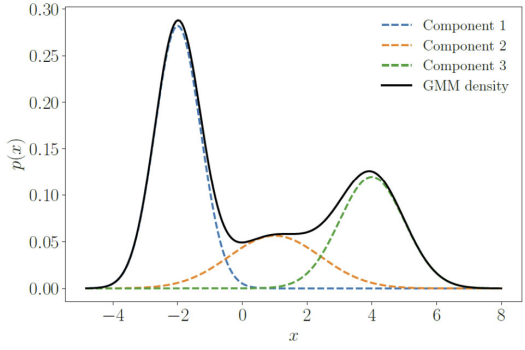

## EM Algorithm

먼저, 학습을 위해 손실 함수를 정의해야 합니다. 손실 함수로는 전체 데이터의 NLL(Negative log likehood), 즉 모든 데이터가 갖는 PDF 값의 곱에 음수 로그를 취한 값을 최소화시키는 것이 학습의 목적입니다.
<font color="#6464FF">EM 알고리즘은 NLL 값을 최소화시키는 GMM PDF의 모수 $\theta = \{\mu_k, \Sigma_k, \pi_k\}$를 추정</font>하는 데 이용되는 알고리즘으로, 그 과정은 다음과 같습니다.


First, we need to define the loss function for training. The loss function we use is the NLL (Negative Log Likelihood), which aims to minimize the negative logarithm of the product of the PDF values of all the data points. The objective of training is to minimize this loss function.

The EM (Expectation Maximization) algorithm is utilized to estimate the parameters $\theta = {\mu_k, \Sigma_k, \pi_k}$ of the GMM PDF that minimize the NLL value. The algorithm iteratively updates the parameter estimates through the following process.



1. $\theta = \{\mu_k, \Sigma_k, \pi_k\}$를 임의의 값으로 초기화합니다.
2. (E-step)
<br>
$N$개의 데이터에 대하여, 그 데이터가 각각의 정규분포에서 관측되었을 확률을 계산합니다. 이를 Responsibility라고 하고, $n$번째 데이터가 $k$번째 정규분포를 통해 관측되는 경우 Responsibility는 다음과 같습니다.

$$
r_{nk} = {
  {\pi_k \mathcal{N}(\boldsymbol x_n|\boldsymbol \mu_k, \boldsymbol \Sigma_k)}
  \over
  {\sum_{j=1}^K {\pi_j \mathcal{N}(\boldsymbol x_n|\boldsymbol \mu_j, \boldsymbol \Sigma_j)}}
}
$$

3. (M-step)
<br>
다음 규칙에 따라 모수를 업데이트합니다.
<br>
$$
\boldsymbol \mu_k^{new} = {{\sum_{n=1}^N r_{nk} \boldsymbol x_n}\over{{\sum_{n=1}^N r_{nk}}}}
$$
$$
\boldsymbol \Sigma_k^{new} = {1\over{N_k}}\sum_{n=1}^N r_{nk}(\boldsymbol x_n - \boldsymbol \mu_k)(\boldsymbol x_n - \boldsymbol \mu_k)^⊤
$$
$$
\pi_k = {{N_k}\over{N}}
$$
<br>
이때, $N_k$는 전체 데이터에서 $k$번째 정규분포가 갖는 Responsibility의 합을 나타내며, $N_k = \sum_{n=1}^N r_{nk}$으로 나타냅니다.
4. E step과 M step을 반복하며 NLL이 감소하는지 확인합니다.

1. Initialize $\theta = {\mu_k, \Sigma_k, \pi_k}$ with arbitrary values.
2. (E-step)
<br>
For each of the $N$ data points, calculate the probability that the data point is observed from each individual Gaussian distribution. This is known as the 'responsibility'. Specifically, for the $n$th data point, if it is observed from the $k$th Gaussian distribution, the responsibility is given by the following equation.

$$
r_{nk} = {
  {\pi_k \mathcal{N}(\boldsymbol x_n|\boldsymbol \mu_k, \boldsymbol \Sigma_k)}
  \over
  {\sum_{j=1}^K {\pi_j \mathcal{N}(\boldsymbol x_n|\boldsymbol \mu_j, \boldsymbol \Sigma_j)}}
}
$$

3. (M-step)
<br>
Update the parameters according to the following rules.
<br>
$$
\boldsymbol \mu_k^{new} = {{\sum_{n=1}^N r_{nk} \boldsymbol x_n}\over{{\sum_{n=1}^N r_{nk}}}}
$$
$$
\boldsymbol \Sigma_k^{new} = {1\over{N_k}}\sum_{n=1}^N r_{nk}(\boldsymbol x_n - \boldsymbol \mu_k)(\boldsymbol x_n - \boldsymbol \mu_k)^⊤
$$
$$
\pi_k = {{N_k}\over{N}}
$$
<br>
Here, $N_k$ represents the sum of responsibilities of the $k$th Gaussian distribution over all the data points. It can be expressed as $N_k = \sum_{n=1}^N r_{nk}$.
4. Repeat the E-step and M-step iteratively while checking if the NLL (Negative Log Likelihood) decreases.

아래 그림의 (a)와 같이 2차원에 분포한 데이터에 대하여 EM 알고리즘을 실행하면, (c)에서 임의의 값으로 모수가 초기화된 후 E step과 M step을 반복하며 (d)~(f)에서 점점 데이터에 맞는 GMM PDF를 찾아가고 (b)와 같이 NLL의 값이 감소하게 됩니다.

When running the EM algorithm on data distributed in a 2D space, as shown in Figure (a), after initializing the parameters with arbitrary values as shown in (c), iteratively performing the E-step and M-step leads to gradually finding the GMM PDF that fits the data in (d) to (f). As a result, the NLL value decreases as shown in (b).

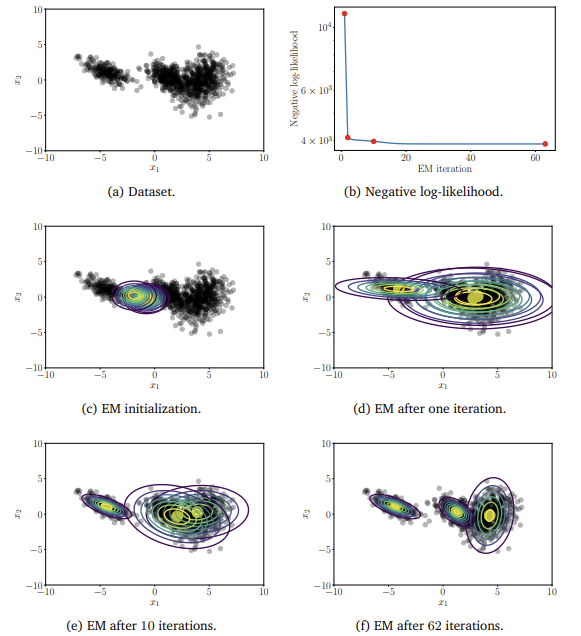

## Modeling a Foreground and a Background using GMM

이제 문제 상황을 해결하기 위하여, 영상의 배경과 전경의 특성을 찾아보고 모델링할 차례입니다. 아래 그림은 Introduction에서 살펴본 영상에서, 배경에 해당하는 도로 위로 전경에 해당하는 빨간 차와 흰 차가 아래쪽으로 달려가고 있는 장면의 인접한 프레임을 겹쳐 나타낸 것입니다. 이때, 화면 상의 임의의 고정된 픽셀 1과 2의 색의 변화를 살펴봅시다. 여기에서는 도로에 있는 두 개의 픽셀을 설정하였습니다.


Now, to solve the problem, it is time to find out and model the characteristics of the background and foreground in the video. The following diagram illustrates overlapping adjacent frames from the video described in the introduction, where the foreground consists of a red car and a white car moving downwards on the road, which represents the background. Let's look at the color variations of two fixed pixels, labeled as 1 and 2, on the screen. In this case, we have chosen two pixels on the road.

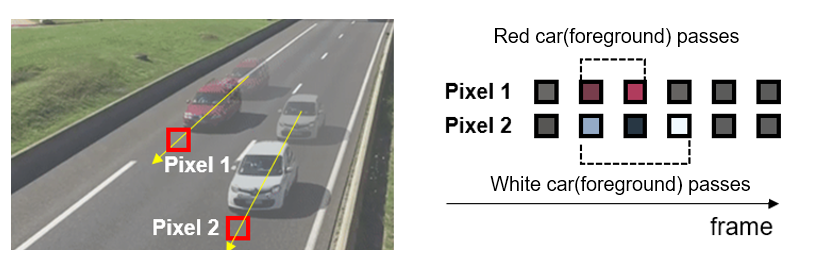

자동차가 지나가기 전 픽셀 1과 픽셀 2는 도로의 색인 회색을 띠고 있다가, 자동차가 지나가는 중에는 픽셀 1과 2의 색은 자동차 위에 있는 색을 띠게 되고 자동차가 지나간 이후 픽셀 1과 2의 색은 다시 도로의 색으로 돌아올 것입니다. 이를 토대로 위 그림에서 픽셀 1과 2의 색이 회색에 가까울 때는 배경 픽셀로, 다른 색이 나타났을 때는 전경 픽셀로 구분할 수 있습니다.


Before the car passes by, pixels 1 and 2 have a gray color, which represents the color of the road. However, as the car passes by, the color of pixels 1 and 2 changes to the color of the car. After the car has passed, pixels 1 and 2 will return to the color of the road. Based on this observation, we can distinguish pixels 1 and 2 in the given diagram as background pixels when they are close to gray, and as foreground pixels when they display different colors.

일반적으로 배경 위로 전경에 해당하는 대상이 지나가는 영상의 경우, 영상의 <font color="#6464FF">고정된 픽셀의 색은 대부분 배경의 색으로 있다가, 전경이 해당 픽셀을 지나가면 다른 색으로 변하고, 지나간 이후에는 다시 배경의 색으로 돌아오게 됩니다.</font>


In general, in videos where foreground objects pass over the background, <font color="#6464FF">the color of a fixed pixel in the video is mostly the color of the background. However, when the foreground passes over that pixel, its color changes to a different color. After the foreground has passed, the pixel returns to the color of the background.</font>

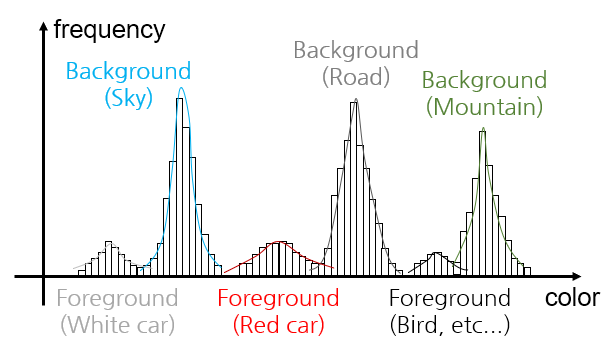

만약 영상에 나타난 전체 프레임, 전체 픽셀의 색 빈도를 조사하여 히스토그램으로 나타내면 위 그림과 같은 형태를 보일 것입니다. 색은 (R, G, B)의 3차원 벡터로 표현되지만, 이해를 돕기 위해 위 그림에서는 1차원에 표현하였습니다.


If we investigate the color frequencies of all frames and all pixels in the video and represent them in a histogram, it will exhibit a similar pattern to the diagram shown above. Colors are represented as 3-dimensional vectors (R, G, B), but to help understanding, they are shown in a 1-dimensional representation in the diagram.

히스토그램에서는 여러 개의 봉우리를 찾을 수 있는데, 배경 픽셀의 빈도가 전경 픽셀에 비해 높으므로 배경을 나타내는 봉우리는 높을 것이고 전경을 나타내는 봉우리는 낮을 것입니다. 예를 들어, 산, 하늘, 도로가 배경에 존재하는 경우에는 산, 하늘, 도로에 해당하는 색의 봉우리가 높게 나타날 것입니다.

In a histogram, it is possible to find multiple peaks, and the peaks corresponding to the background will be higher compared to those representing the foreground. For example, if there are mountains, sky, and a road in the background, the peaks corresponding to the colors of the mountains, sky, and road will appear higher in the histogram.

따라서, <font color="#6464FF">각각의 픽셀의 색 빈도 분포를 $K$개의 정규분포</font>(위 그림에서는 $K=3$ 이상)<font color="#6464FF">를 갖는 GMM으로 모델링한 뒤, 특정 프레임의 특정 픽셀이 갖는 GMM PDF의 값이 특정 값보다 높으면 배경으로, 낮으면 전경 픽셀로 구분</font>하는 방법을 생각할 수 있습니다.

Therefore, we can consider modeling <font color="#6464FF">the color frequency distribution of each pixel using a Gaussian Mixture Model (GMM) with $K$ Gaussian distributions</font> (in the given diagram, $K$ is greater than or equal to 3). After modeling, we can distinguish whether a specific pixel in a specific frame belongs to the background or foreground by comparing its GMM PDF value with a certain threshold. <font color="#6464FF">If the value is higher than the threshold, it is classified as a background pixel, and if it is lower, it is classified as a foreground pixel.</font>

## Implementaion

### Getting a Video

여기에서는 GMM 모델과 EM 알고리즘을 이용하여 실제로 배경을 제거하는 코드를 작성합니다. 먼저 배경 제거에 필요한 영상을 준비합니다. 


From now on, we will write code using the GMM model and the EM algorithm to actually remove the background. We need to prepare the video first.

In [ ]:
# Video(GIF file)
gif_link = "https://drive.google.com/uc?export=download&id=1DSZ1qqm3kKCS4-nk36pZYmFfmCkVhBry"
Image(url=gif_link)

다음으로 특정 픽셀의 색을 가져오기 위하여 영상을 배열로 변환하고, 영상의 프레임 수와 크기를 구합니다.

Next, to retrieve the color of a specific pixel, convert the video into an array of frames, and get the number of frames and the size of the video.

In [ ]:
def get_frames_from_link(gif_link):
    """
    Generate a tensor representing the video, from a downloadable link 'gif_link'.
    The shape of resulting tensor is (num_frames, height, width, 4).
    Last dimension '4' represents [R, G, B, Transparency].
    """

    # Download GIF
    response = requests.get(gif_link)
    gif_content = response.content
    gif_file = io.BytesIO(gif_content)

    # Convert a GIF file to array of frame.
    frames = np.array(imageio.mimread(gif_file, memtest=False))

    return frames

In [ ]:
shape = get_frames_from_link(gif_link).shape
print(f"Shape of frames: {shape}")
print(f"num_frames: {shape[0]}, height: {shape[1]}, width: {shape[2]}")

Shape of frames: (48, 320, 320, 4)
num_frames: 48, height: 320, width: 320


### Showing Frequencies of Colors

먼저, 영상의 색 빈도를 나타내 봅시다. 색은 [R, G, B]의 3차원이므로, 그대로 빈도를 나타낼 경우 영상의 색 빈도 분포가 GMM에 들어맞는지 직관적으로 이해하기 어렵습니다. 따라서 각각의 R, G, B의 빈도를 히스토그램으로 나타내 보겠습니다.


First, let's visualize the color frequencies of the video. Since colors are represented by the 3-dimensional values [R, G, B], it can be difficult to intuitively understand if the color frequency distribution of the video fits into a GMM by directly representing the frequencies. Therefore, let's plot the histograms for each of the R, G, and B channels to visualize their marginal frequencies.

만약 <font color="6464FF">색의 빈도 분포가 GMM을 따른다면, GMM을 구성하는 다변수 정규분포의 Marginal PDF 역시 정규분포의 PDF이므로 R, G, B의 빈도 역시 정규분포를 따를 것</font>으로 생각할 수 있습니다.

<font color="6464FF">If the color distribution follows a GMM</font>, then the marginal PDFs of the multivariate normal distributions that constitute the GMM will also be normal distribution PDFs. Therefore, we can assume that <font color="6464FF">the frequencies of R, G, and B will also follow normal distributions</font> as well.



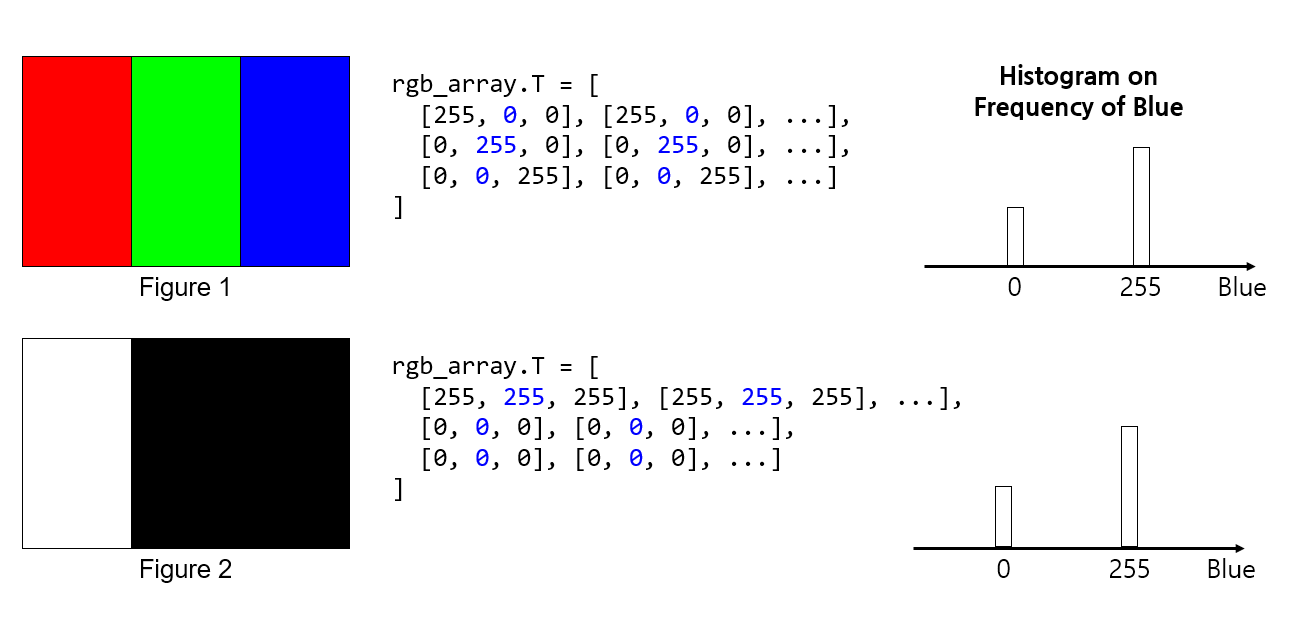

여기서 주의해야 할 점이 있습니다. [R, G, B]의 빈도를 각각의 히스토그램으로 따로 나타내는 것은 GMM에 대한 가정이 합리적인지 확인하는 하나의 수단으로, <font color="#6464FF">실제 영상 데이터에 대한 모든 정보를 보존하는 것은 아닙니다.</font>

There is an important point we should check. Representing the frequency of [R, G, B] separately in individual histograms is just one way to verify the assumption of GMM's reasonableness. However, <font color="#6464FF">it does not preserve all the information about the actual video data.</font>

예를 들어, 위의 그림 1과 2는 완전히 다른 색 분포를 가지고 있습니다. 그림 1은 빨간색, 초록색, 파란색이 각각 1/3의 비율로 나타나는 반면, 그림 2는 흰색과 검정색이 각각 1/3과 2/3의 비율로 나타납니다. 하지만, R, G, B 값을 따로 보면 빈도가 완전히 같기 때문에, R, G, B 히스토그램 모두 같게 나타나고 이는 영상의 정보를 제대로 보존하지 못하게 됩니다.


For example, in the given figures 1 and 2, they have completely different color distributions. Figure 1 has equal proportions of red, green, and blue, while figure 2 has a ratio of 1/3 for white and 2/3 for black. However, if we consider the R, G, B values separately, the frequencies would appear the same, resulting in identical R, G, B histograms. This would fail to properly preserve the information of the video.

따라서, 이러한 형태의 정보 손실을 방지하기 위하여 실제로 <font color='#6464FF'>GMM을 이용한 색 빈도 측정과 EM 알고리즘을 이용한 학습은 [R, G, B] 벡터를 하나의 변수로 생각</font>해야 합니다.

Therefore, to prevent such information loss, in practice, <font color='#6464FF'>we should consider the use of GMM for color frequency estimation and EM algorithm with [R, G, B] vectors treated as a single variable.</font> This approach allows us to properly capture the color distributions and learn the parameters using the EM algorithm.

아래 두 함수는 특정 픽셀의 프레임별 색을 배열에 저장하고, 이를 R, G, B 각각에 대한 히스토그램으로 나타내는 함수입니다.


The following two functions store the colors of a specific pixel across frames in an array and represent them as histograms for each R, G, and B channel.

In [ ]:
def generate_rgb_array(frames):
    """
    Generates an array of all pixels of all frames in the video.
    The shape of resulting tensor is (3, num_frames * width * height).
    """
    
    num_frames, height, width = frames.shape[:3]  # Get dimension of the video

    rgb_array = []

    # Get [R, G, B] vector from each pixel.
    for y in range(height):
        for x in range(width):
          for frame in frames:
              pixel_color = frame[y, x][:3]
              rgb_array.append(pixel_color)
    return np.array(rgb_array).T

In [ ]:
def show_rgb_hist(rgb_array):
    """
    Shows histogram from "rgb_array", which is the output from function "generate_rgb_array(frames)".
    """
    
    # Separates R, G, B factors.
    r_values = rgb_array[0]
    g_values = rgb_array[1]
    b_values = rgb_array[2]

    fig, axes = plt.subplots(3, 1, figsize=(8, 6))

    # Show a histograms with respect to R frequency.
    axes[0].hist(r_values, bins=256, color='red')
    axes[0].set_title('Histogram of R Values')
    axes[0].set_xlabel('R')
    axes[0].set_ylabel('Frequency')

    # Show a histograms with respect to G frequency.
    axes[1].hist(g_values, bins=256, color='green')
    axes[1].set_title('Histogram of G Values')
    axes[1].set_xlabel('G')
    axes[1].set_ylabel('Frequency')

    # Show a histograms with respect to B frequency.
    axes[2].hist(b_values, bins=256, color='blue')
    axes[2].set_title('Histogram of B Values')
    axes[2].set_xlabel('B')
    axes[2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

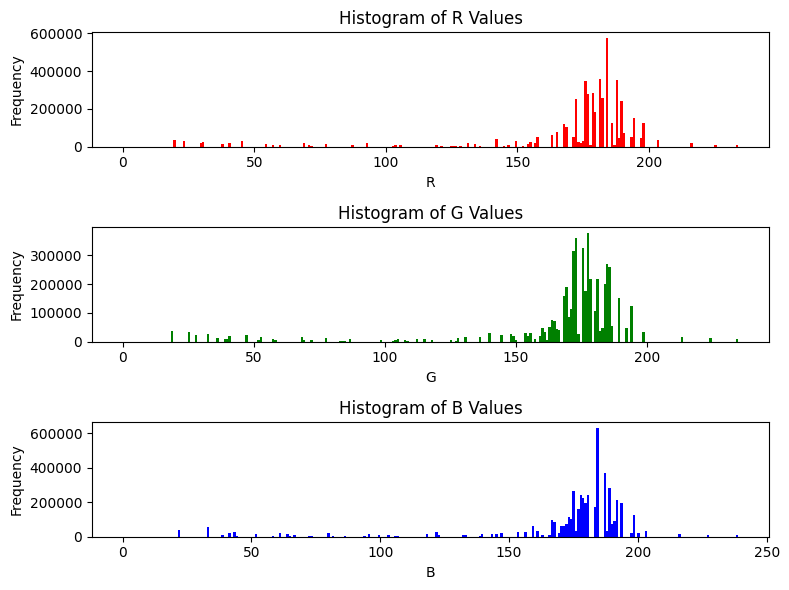

In [ ]:
gif_link = "https://drive.google.com/uc?export=download&id=1DSZ1qqm3kKCS4-nk36pZYmFfmCkVhBry"
frames = get_frames_from_link(gif_link)
rgb_array = generate_rgb_array(frames)
show_rgb_hist(rgb_array)

색 빈도의 히스토그램을 보면 R, G, B 값 모두 150\~200 사이의 값이 가장 많이 나타나므로 배경 부분에 해당하는 픽셀이라고 추측할 수 있으며, <font color="#6464FF">분포의 중심 부분이 가장 큰 빈도를 가지고 있고 중심에서 멀어질수록 빈도가 감소하는 특성으로 보아 정규분포로 모델링하기에 적절하다는 것을 확인</font>할 수 있습니다.

We can observe that the values for R, G, and B are most frequently in the range of 150 to 200. Therefore, we can speculate that these pixels correspond to the background region. Additionally, <font color="#6464FF">the fact that the distribution has the highest frequency at the center and decreases as it moves away from the center suggests that modeling it with a normal distribution is appropriate</font>.

주의할 점은, 가장 많은 R, G, B 값이 나타나는 부분이 모두 170\~180 근처라고 해서 배경 픽셀이 [R, G, B] = [170, 170, 170]에 가깝다고 해석하면 안 된다는 점입니다. 색 빈도에 해당하는 PDF가 있다면, 위 히스토그램은 Marginal PDF에 해당하는 것이기 때문입니다.


One important thing to note is that we should not interpret the fact that the most frequent values for R, G, and B are around 170-180 as implying that the background pixels are close to [R, G, B] = [170, 170, 170]. This is because the histogram represents the Marginal PDF, and not the actual PDF corresponding to the color frequencies.

### Applying the EM Algorithm with Sampling

그렇다면 전체 색의 분포가 3차원 색 벡터를 확률변수로 하는 GMM을 따른다고 가정하고, EM 알고리즘을 적용해 봅시다.

Then, let's assume that the overall color distribution follows a Gaussian Mixture Model (GMM) with the color vectors as a 3-dimensional random variable, and apply the EM algorithm.

1. $\theta = \{\mu_k, \Sigma_k, \pi_k\}$를 임의의 값으로 초기화합니다.
<br>
Initialize $\theta = \{\mu_k, \Sigma_k, \pi_k\}$ with random numbers.

In [ ]:
def initialize_theta(K):
    """
    Initializes the means, covariance matrices, and weights with random values for K components.
    The data is a 3-dimensional vector (R, G, B).
    """
    
    means = np.zeros((K, 3))
    covs = np.zeros((K, 3, 3))
    for k in range(K):
        means[k] = np.random.uniform(low=0, high=255, size=(3,))  # Make random number between 0~255.
        covs[k] = np.eye(3) * 1000
      
    weights = np.ones((K, 1)) / K

    return means, covs, weights

추가적으로, GMM PDF의 값을 쉽게 계산하기 위한 함수와 학습이 잘 진행되고 있는지 확인하기 위해 NLL을 계산하는 함수를 정의합니다.

In addition, define a function for easier calculation of GMM PDF values and checking the progress of the training by calculating the NLL:

In [ ]:
def calculate_nll(rgb_array, means, covs, weights):
    """
    Calculates the negative log-likelihood (NLL) of the entire video for the current distribution.
    The rgb_array has a shape of (3, num_frames * width * height).
    """

    gmm_nll = 1e-100
    for k in range(len(weights)):
            gmm_nll += weights[k] * multivariate_normal.pdf(mean=means[k,:].ravel(), cov=covs[k,:,:],
                                                            x=rgb_array.T, allow_singular=True)
    
    return -np.sum(np.log(gmm_nll))

2. (E-step)
<br>
$N$개의 데이터에 대하여, 그 데이터가 각각의 정규분포에서 관측되었을 확률을 계산합니다. 이를 Responsibility라고 하고, $n$번째 데이터가 $k$번째 정규분포를 통해 관측되는 경우 Responsibility는 다음과 같습니다.
<br>
For $N$ data points, this function calculates the probability of each data point being observed from each of the Gaussian distributions. This is called the responsibility, and for the $n$th data point being observed from the $k$th Gaussian distribution, the responsibility is calculated as follows:
<br><br>
$$
r_{nk} = {
  {\pi_k \mathcal{N}(\boldsymbol x_n|\boldsymbol \mu_k, \boldsymbol \Sigma_k)}
  \over
  {\sum_{j=1}^K {\pi_j \mathcal{N}(\boldsymbol x_n|\boldsymbol \mu_j, \boldsymbol \Sigma_j)}}
}
$$

3. (M-step)
<br>
다음 규칙에 따라 모수를 업데이트합니다.
<br>
Update the parameters according to the following rules.
<br><br>
$$
\boldsymbol \mu_k^{new} = {{\sum_{n=1}^N r_{nk} \boldsymbol x_n}\over{{\sum_{n=1}^N r_{nk}}}}
$$
$$
\boldsymbol \Sigma_k^{new} = {1\over{N_k}}\sum_{n=1}^N r_{nk}(\boldsymbol x_n - \boldsymbol \mu_k)(\boldsymbol x_n - \boldsymbol \mu_k)^⊤
$$
$$
\pi_k = {{N_k}\over{N}}
$$
<br>
이때, $N_k$는 전체 데이터에서 $k$번째 정규분포가 갖는 Responsibility의 합을 나타내며, $N_k = \sum_{n=1}^N r_{nk}$으로 나타냅니다.
<br>
Here, $N_k$ represents the sum of responsibilities that the $k$th Gaussian distribution has over all the data points. It is calculated as $N_k = \sum_{n=1}^N r_{nk}$, where $r_{nk}$ denotes the responsibility of the $n$th data point for the $k$th Gaussian distribution.

4. E step과 M step을 반복하며 NLL이 감소하는지 확인합니다.
<br>
Repeat the E-step and M-step iteratively while checking if the NLL (Negative Log-Likelihood) is decreasing.

그렇다면, 이제 본격적으로 EM 알고리즘을 이용하여 학습을 진행하겠습니다.

From now on, let's train the GMM model using the EM algorithm.

위에서 살펴본 EM 알고리즘과 원리는 동일하지만, 숫자 연산에서의 오류를 피하기 위하여 0에 가까운 수를 ```SMALL_NUMBER```라는 변수로 사용하였습니다.

The EM algorithm we discussed earlier remains the same in principle, but to avoid numerical errors in computations, we have introduced a variable called SMALL_NUMBER, which represents a value close to zero.

또한, ```rgb_array``` 안에는 $num\_frames × height × width$개(이 영상의 경우 4,915,200개)의 RGB 벡터가 있어, E step과 M step에서 이를 모두 사용하면 실행 시간이 길어집니다(실험 결과, 1회의 iteration 동안 약 5초가 소요되었습니다). 따라서, <font color="#6464FF">E step과 M step에서 RGB 데이터를 모두 사용하지 않고, 그 중 ```sample_size```개만을 임의로 추출하여 PDF를 계산</font>할 것입니다.

Furthermore, the rgb_array contains a total of $num_frames × height × width$ (in this case, 4,915,200) RGB vectors, and using all of them in the E step and M step would result in longer execution time (based on experiments, it took approximately 5 seconds for one iteration). Therefore, <font color="#6464FF">instead of using all RGB data in the E step and M step, we will randomly sample only sample_size number of vectors to calculate the PDF</font>.

In [ ]:
def em_algorithm(rgb_array, K, sample_size):
    """
    픽셀 (x, y)의 시간적 데이터에 대하여 EM 알고리즘을 적용합니다.
    적용 후 K개 정규분포의 평균, 공분산 행렬, weights와 학습 과정의 NLL 배열을 반환합니다.
    """

    SMALL_NUMBER = 1e-10        # Prevent numerical exception
    CONVERGE_THRESHOLD = 100    # Check for convergence of NLL
    NUM_EM_ITER = 400           # Maximum number of iteration.

    # 0. Sample data
    N = rgb_array.shape[1]
    # Get samples of 'sample_size' among (3, num_frame * height * width) RGB values.
    sample_indices = random.sample(range(N), sample_size)

    # 1. Parameter initialization
    means, covs, weights = initialize_theta(K)

    # Calculate the first NLL value with sampling.
    NLL = [calculate_nll(rgb_array[:, sample_indices], means, covs, weights) * N / sample_size]

    # 2~4. Repeat E-step and M-step
    r = np.zeros((K, sample_size)) + SMALL_NUMBER
    for em_iter in range(NUM_EM_ITER):
        sample_indices = random.sample(range(N), sample_size)
        # E step (with sampling)
        for k in range(K):
            r[k] = weights[k] * multivariate_normal.pdf(mean=means[k,:], cov=covs[k,:,:], x=rgb_array[:, sample_indices].T, allow_singular=True)
        r += SMALL_NUMBER
        r /= np.sum(r, axis=0)

        # M step (with sampling)
        N_k = np.sum(r, axis=1)
        for k in range(K):
            # Update mean vector
            means[k] = np.sum(r[k] * rgb_array[:, sample_indices], axis=1) / N_k[k]
            # Update covariance matrix
            diff = rgb_array[:, sample_indices] - means[k:k+1].T
            _tmp = np.sqrt(r[k:k+1]) * diff
            covs[k] = np.inner(_tmp, _tmp) / N_k[k]

        # Update weights
        weights = N_k / sample_size;
        weights += SMALL_NUMBER
        weights /= np.sum(weights)

        # Calculate NLL with sampling
        NLL += [calculate_nll(rgb_array[:, sample_indices], means, covs, weights) * N / sample_size]

        # Terminate iteration on convergence
        if 0 <= NLL[em_iter + 1] - NLL[em_iter] < CONVERGE_THRESHOLD:
            break

    return means, covs, weights, NLL

In [ ]:
def plot_marginal_gmm(em_result):
    """
    The resulting GMM is a PDF for (R, G, B) vectors.
    To visualize it, we represent the Marginal PDF for each axis (R, G, B) of the GMM and its subcomponents.
    The Marginal PDF of the GMM is shown as a solid line,
    while the Marginal PDF of the subcomponents with applied weight values is shown as a dotted line.
    """
    
    means, covs, weights, NLL = em_result

    print(f"Converged on the {len(NLL)}th iteration.\n")
    print(f"means:\n{means}\n\n")
    print(f"covs:\n{covs}\n\n")
    print(f"weights:\n{weights}\n\n")

    # Specify the x-range for plotting PDFs
    x_range = np.linspace(0, 255, 255)

    # Marginal GMM PDF graphs for each color component
    for idx, color in enumerate(['Red', 'Green', 'Blue']):
        plt.figure(figsize=(8, 6))
        plt.title(f"Marginal GMM PDF for the {color} Component")
        plt.xlabel(f"{color} Value")
        plt.ylabel("PDF")
        gmm_values = np.zeros_like(x_range)  # Stores GMM values
        for k in range(len(weights)):
            pdf = multivariate_normal.pdf(x_range, mean=means[k][idx], cov=covs[k][idx, idx], allow_singular=True)
            plt.plot(x_range, pdf, color="grey", linestyle="dotted", zorder=100)   # Plot subcomponent PDFs (dotted line)
            gmm_values += pdf * weights[k]
        plt.plot(x_range, gmm_values, color=color, label=f"Marginal GMM PDF for {color}")  # Plot GMM PDF (solid line)
        plt.legend()
        plt.show()

    # NLL graph
    plt.figure(figsize=(8, 6))
    plt.title("Negative Log Likelihood")
    plt.xlabel("# of iteration")
    plt.ylabel("NLL")
    plt.plot(NLL)
    plt.show()


Converged on the 401th iteration.

means:
[[180.71000996 175.77007307 180.49281637]
 [154.19537949 152.8996347  161.34729076]
 [ 62.98719536  60.73702591  69.88037631]]


covs:
[[[ 142.93376749  158.95781692  163.31187933]
  [ 158.95781692  182.33013545  189.39525217]
  [ 163.31187933  189.39525217  200.88613354]]

 [[ 565.15521291  631.98129852  685.87784894]
  [ 631.98129852  786.93502694  892.83989079]
  [ 685.87784894  892.83989079 1054.82075134]]

 [[2450.58962991 2166.72337191 2002.76091479]
  [2166.72337191 1970.0513457  1845.80736676]
  [2002.76091479 1845.80736676 1765.90043802]]]


weights:
[0.82802416 0.09906425 0.07291159]




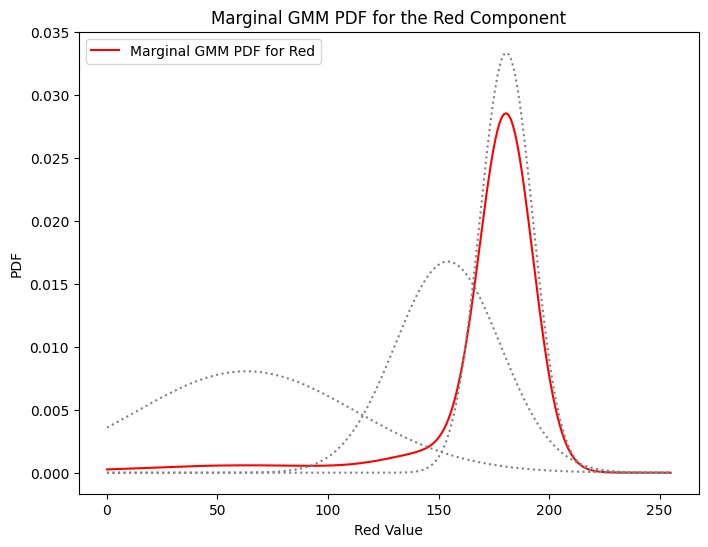

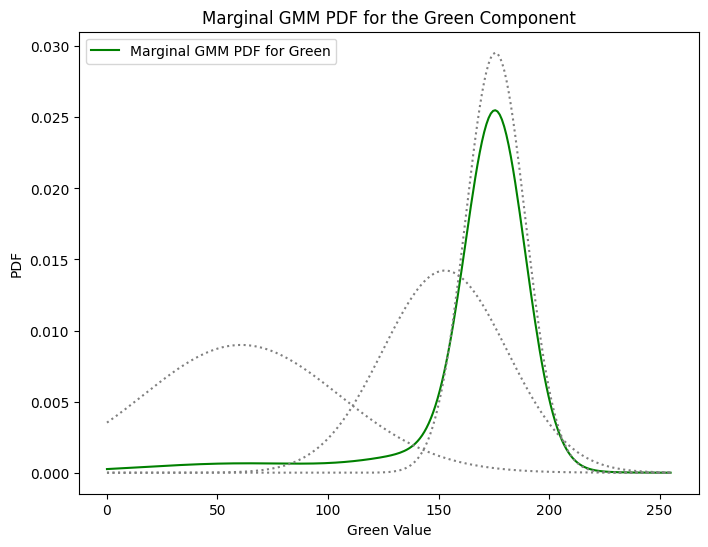

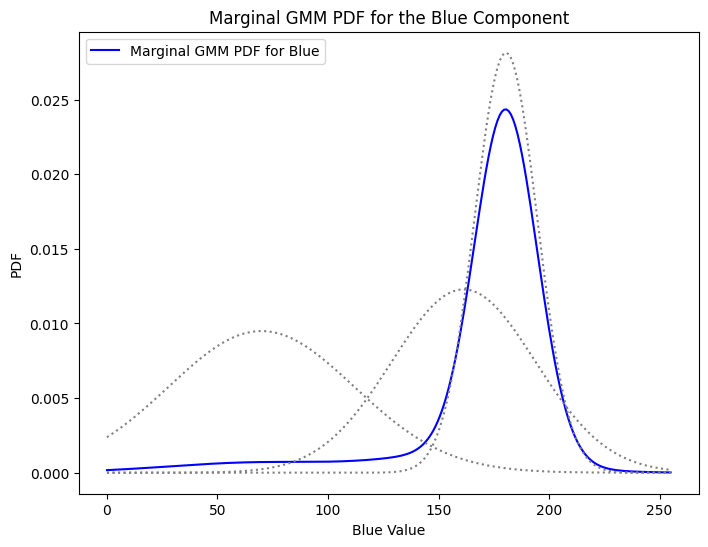

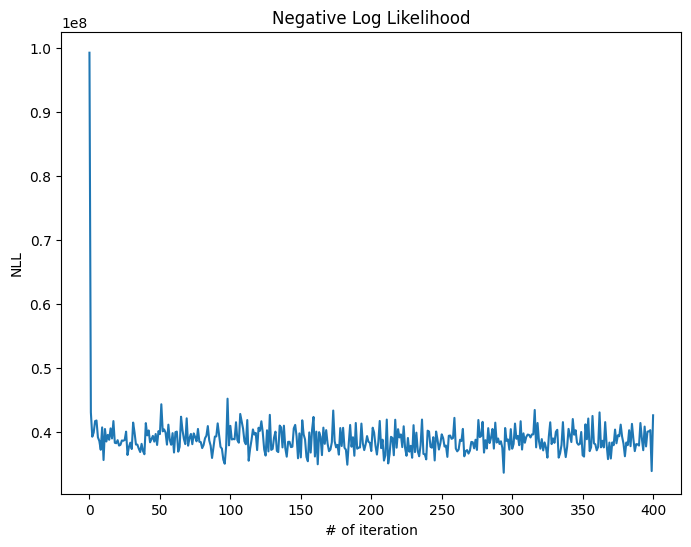

In [ ]:
gif_link = "https://drive.google.com/uc?export=download&id=1DSZ1qqm3kKCS4-nk36pZYmFfmCkVhBry"
frames = get_frames_from_link(gif_link)
rgb_array = generate_rgb_array(frames)
em_result = em_algorithm(rgb_array, K=3, sample_size=128)
plot_marginal_gmm(em_result)

EM 알고리즘으로 학습을 진행한 결과, GMM의 R, G, B에 대한 Marginal PDF의 모양이 위에서 살펴본 R, G, B의 히스토그램과 비슷한 모양을 가지는 것을 확인할 수 있습니다.

After training with the EM algorithm, we can observe that the shape of the Marginal PDF for R, G, and B in the GMM is similar to the histograms we examined earlier for R, G, and B.

### Classifying Forground & Background with Trained GMM

GMM을 추정하였다면, 특정 프레임의 특정 픽셀이 배경인지 전경인지 구분해야 합니다. 이때, <font color="#6464FF">픽셀의 (R, G, B) 벡터를 GMM PDF에 대입한 Likelihood가 특정 값 이상이면 배경으로 판단하고, 그렇지 않으면 전경으로 판단한 뒤 각 픽셀이 배경인지 전경인지를 각각 0과 1로 표시한 전경 마스크를 획득</font>합니다.


Once the GMM is estimated, it is necessary to distinguish whether a specific pixel in a particular frame belongs to the background or the foreground. In this case,<font color="#6464FF"> if the likelihood obtained by evaluating the pixel's (R, G, B) vector using the GMM PDF is above a certain threshold, it is considered as background. Otherwise, it is considered as foreground. By doing this for each pixel, a foreground mask is obtained where each pixel is labeled as 0 for background and 1 for foreground.</font>

배경과 전경을 구분할 특정 값을 정하기 위해, 학습이 완료된 GMM에 각 픽셀의 데이터를 입력하고 Likelihood에 대한 대략적인 정보와 히스토그램을 출력해 봅시다.

To determine a specific threshold for distinguishing background and foreground, let's input the data of each pixel into the trained GMM and examine the approximate information and histogram of the likelihood.

In [ ]:
def get_likelihood(rgb_array, em_result):
    """
    Calculates the likelihood by inputting the values of the [R, G, B] array rgb_array into the trained GMM.
    """

    means, covs, weights, _ = em_result  # Parameters of the trained GMM

    gmm_likelihood = np.zeros(rgb_array.shape[1])  # Stores the likelihood of all pixels in all frames
    for k in range(len(weights)):
        gmm_likelihood += weights[k] * multivariate_normal.pdf(mean=means[k,:].ravel(), cov=covs[k,:,:], x=rgb_array.T, allow_singular=True)

    return gmm_likelihood


def show_likelihood(gmm_likelihood):
    """
    Displays the results of get_likelihood(rgb_array, em_result) as a histogram and provides some statistics.
    """

    # Statistics and histogram of the likelihood
    print(f"Max: {max(gmm_likelihood): .5f}, Min: {min(gmm_likelihood): .5f}, ")
    print(f"Avg: {sum(gmm_likelihood) / len(gmm_likelihood): .5f}, Median: {np.median(gmm_likelihood): .5f}")
    for percentile in [10, 20, 30, 40]:
        print(f"{percentile}% Percentile: {np.percentile(gmm_likelihood, percentile): .3e}")
    print()
    plt.hist(gmm_likelihood, bins=100, edgecolor='black')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Likelihoods')
    plt.show()


Max:  0.00100, Min:  0.00000, 
Avg:  0.00050, Median:  0.00056
10% Percentile:  3.743e-06
20% Percentile:  7.171e-05
30% Percentile:  3.493e-04
40% Percentile:  4.710e-04



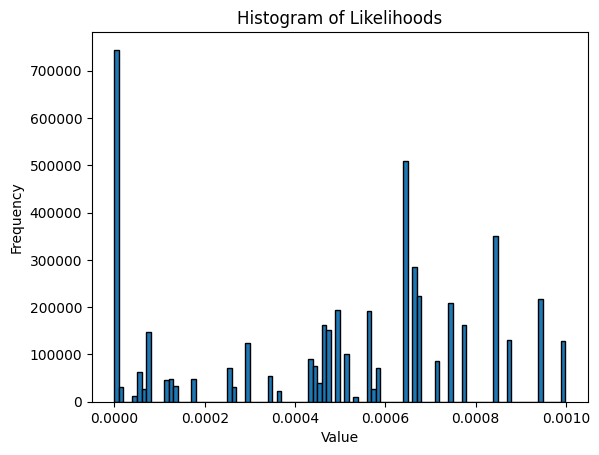

In [ ]:
show_likelihood(get_likelihood(rgb_array, em_result))

Likelihood의 분포와 주어진 영상의 특징을 고려하여, <font color="#6464FF">'배경과 전경을 구분할 특정 값'을 Likelihood의 10% percentile</font>로 정하였습니다. 이제 이 값을 토대로, 영상의 픽셀들을 전경과 배경으로 분류해 봅시다.


Taking into account the distribution of likelihood and the characteristics of the given image, I chose the<font color="#6464FF"> 'specific value for differentiating background and foreground' as the 10th percentile of the likelihood.</font> Now, let's use this value to classify the pixels in the image into foreground and background.

In [ ]:
def foreground_mask(rgb_array, em_result, fg_percent):
    """
    Returns a foreground mask with the same dimensions as rgb_array.
    Classifies (fg_percent)% of pixels as foreground.
    Foreground pixels have the color [255, 255, 255], while background pixels have the color [0, 0, 0].
    """

    # Set the (fg_percent)% percentile of the likelihood as the threshold to classify pixels as foreground
    THRESHOLD = np.percentile(get_likelihood(rgb_array, em_result), fg_percent)

    means, covs, weights, _ = em_result  # Parameters of the trained GMM

    rgb_mask = np.zeros(rgb_array.shape[1])
    for k in range(len(weights)):
        rgb_mask += weights[k] * multivariate_normal.pdf(mean=means[k,:].ravel(), cov=covs[k,:,:], x=rgb_array.T, allow_singular=True)
    
    # Each pixel in rgb_array is 0 for background and 1 for foreground
    rgb_mask = list(map(lambda pdf: [255, 255, 255] if pdf < THRESHOLD else [0, 0, 0], rgb_mask))
    
    return np.array(rgb_mask).T


이로서 ```rgb_array```와 차원이 같은 전경 마스크를 획득할 수 있게 되었습니다. 이제 이 마스크의 차원을 다시 원래 GIF 영상과 같은 차원으로 만들어준 후, 영상을 재생합니다.


With this, we have obtained a foreground mask with the same dimensions as rgb_array. Now, we need to reshape the dimensions of this mask to match the original GIF video, and then play the video.

In [ ]:
def apply_mask(rgb_array, mask):
    """
    It returns the RGB array of the original video with the mask applied.
    """

    return rgb_array * (mask / 255)

In [ ]:
def restore_gif_tensor(rgb_array, frames_shape):
    """
    From the array [R, G, B] obtained as the result of generate_rgb_array(frames),
    create an array of frames that can be used to generate a GIF.
    The transparency value is fixed at 255.
    """

    num_frames, height, width = frames_shape[:3]  # Get dimensions of the video

    restored_tensor = np.zeros((num_frames, height, width, 4), dtype=np.uint8)
    for frame_idx in range(num_frames):
        for y in range(height):
            for x in range(width):
                rgb_values = rgb_array[:, frame_idx + (y * width + x) * num_frames]
                restored_tensor[frame_idx, y, x, :3] = rgb_values
                restored_tensor[frame_idx, y, x, 3] = 255
    return restored_tensor

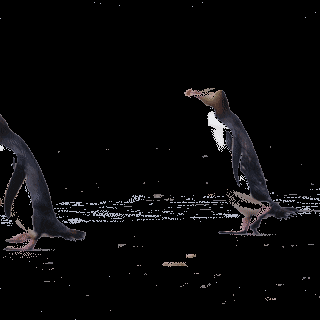

In [ ]:
# Creates a mask that classifies frames with likelihood below the 10th percentile as background
mask_10 = foreground_mask(rgb_array, em_result, fg_percent=10)

# Adjusts the dimensions of the foreground mask to match the original video
output_gif = [frame[:, :, :].astype('uint8') for frame in restore_gif_tensor(apply_mask(rgb_array, mask_10), frames.shape)]

# Save and display the result.
output_path = 'output.gif'
imageio.mimsave(output_path, output_gif)
Image(output_path)

이렇게 해서, 주어진 영상에 등장하는 RGB 벡터의 빈도를 GMM으로 모델링하고, EM 알고리즘을 적용하여 배경을 제거하였습니다.

Using this approach, we modeled the frequency of RGB vectors appearing in the given video using a GMM and applied the EM algorithm to remove the background.

## Playground

여러 가지 영상에서 K, RGB 표본의 수, 전경 마스크의 비율을 변화시켜 배경 제거를 시도한 결과를 볼 수 있습니다. 전경의 색이 어두우면 배경을 제거한 결과를 확인하기 어렵기 때문에 여기에서는 전경 마스크를 원본 영상에 적용하지 않고, 전경 마스크만을 흰색으로 출력합니다.

You can see the results of attempting background removal by varying the values of K, the number of RGB samples, and the foreground mask ratio in different videos. Since it is difficult to observe the results of background removal when the foreground colors are dark, in this case, we only display the foreground mask as white without applying it to the original video.

In [ ]:
# File names and downloadable links
google_drive_link_base = "https://drive.google.com/uc?export=download&id="
file_link = {
    "penguin.gif": google_drive_link_base + "1DSZ1qqm3kKCS4-nk36pZYmFfmCkVhBry",
    "turtle.gif": google_drive_link_base + "1WBZ1T1jAMhZdwlr72BKNQPex9cTonRVM",
    "parrot.gif": google_drive_link_base + "1cjderEFdMo4MW6GU8sjGVSj2-6uoO4gA",
    "duck.gif": google_drive_link_base + "1IBQANVXllq3WVpLQpAO4FeKHi-HllLNV",
    "jirmy.gif": google_drive_link_base + "1bEB6O5gTxGTHqtlPMReku-a1vCUaG1QR",
    "seal.gif": google_drive_link_base + "1Wrlcl7SsoYGc_CideGFkmPLeeXi1NtId",
    # You can add downloadable link of gif file.
}

# Make a selector, sliders and button.
selection = widgets.Dropdown(
    options=list(file_link.keys()),
    description="File: ",
    value=None
)

K, sample_size, fg_percentile = 3, 128, 10

slider_K = widgets.IntSlider(value=3, min=2, max=7, description='K')
slider_sample_size = widgets.IntSlider(value=128, min=2, max=min(8192, rgb_array.shape[1]), step=1, description='Sample Size')
slider_fg_percentile = widgets.IntSlider(value=10, min=1, max=100, step=1, description='% of Mask')
button = widgets.Button(description='Run')

# Event handler
def on_change_K(change):
    global K
    K = change.new 

def on_change_sample_size(change):
    global sample_size
    sample_size = change.new 

def on_change_fg_percentile(change):
    global fg_percentile
    fg_percentile = change.new 

def on_button_click(button):
    print(f"\nFile: {selection.value}, K: {K}, Sample size: {sample_size}, % of mask: {fg_percentile}")

    time_stamp = time.time()  # Measures running time.
    print(f"1. Fetching {selection.value}... ", end="")
    gif_link = file_link[selection.value]
    frames = get_frames_from_link(gif_link)
    rgb_array = generate_rgb_array(frames)
    print(f"Done. time: {time.time() - time_stamp: .5f} sec")
    time_stamp = time.time()

    print(f"2. EM Iterating... ", end="")
    em_result = em_algorithm(rgb_array, K=slider_K.value, sample_size=slider_sample_size.value)
    print(f"Done. time: {time.time() - time_stamp: .5f} sec, time/iteration: {(time.time() - time_stamp) / len(em_result[3]): .5f} sec")
    time_stamp = time.time()

    print(f"3. Calculating masks... ", end="")
    mask = foreground_mask(rgb_array, em_result, fg_percent=slider_fg_percentile.value)
    print(f"Done. time: {time.time() - time_stamp: .5f} sec")
    time_stamp = time.time()

    print(f"4. Builing GIF file... ", end="")
    output_gif = [frame[:, :, :].astype('uint8') for frame in restore_gif_tensor(mask, frames.shape)]
    print(f"Done. time: {time.time() - time_stamp: .5f} sec")
    time_stamp = time.time()

    print(f"5. Showing GIF file...\n")
    output_path = 'output.gif'
    imageio.mimsave(output_path, output_gif)
    display(Image(url=file_link[selection.value]))
    display(Image(output_path))

selection.value = list(file_link.keys())[0]
slider_K.observe(on_change_K, "value")
slider_sample_size.observe(on_change_sample_size, "value")
slider_fg_percentile.observe(on_change_fg_percentile, "value")
button.on_click(on_button_click)
display(selection, slider_K, slider_sample_size, slider_fg_percentile, button)

Dropdown(description='File: ', options=('penguin.gif', 'turtle.gif', 'parrot.gif', 'duck.gif', 'jirmy.gif', 's…

IntSlider(value=3, description='K', max=7, min=2)

IntSlider(value=128, description='Sample Size', max=8192, min=2)

IntSlider(value=10, description='% of Mask', min=1)

Button(description='Run', style=ButtonStyle())

## Discussion

### Observations

먼저 GMM에 사용되는 하위 정규분포의 개수인 <font color="#6464FF">$K$ 값의 변화</font>에 따라 결과가 어떻게 달라지는지 살펴봅시다.


First, let's examine how the results vary with the change in <font color="#6464FF">the number of component distributions, denoted by $K$</font>, used in the GMM.

다음 두 결과는 영상 "turtle.gif"에서, 다른 설정은 같게 하고 $K$의 값을 2와 7로 다르게 설정한 결과입니다. 원본 영상에서 거북이가 들고 있는 광선검의 색을 보면, 가운데 부분은 흰색이고 이를 둘러싸고 있는 빛은 각각 노란색과 초록색입니다.


The following two results are obtained from the "turtle.gif" video, with all other settings kept the same, except for the value of $K$, which is set to 2 and 7, respectively. If we look at the color of the lightsaber held by the turtle in the original video, we can see that the central part is white, surrounded by yellow and green colors, respectively.

$K=2$로 학습을 하였을 때는 광선검의 분포를 하나로 구분하는 반면, $K=7$로 학습을 하였을 때는 광선검의 내부와 외부의 색을 각각 다르게 판단하는 것을 볼 수 있습니다. EM 알고리즘의 E step과 M step을 각각 1회 실행하는 데 걸린 시간은 $K=7$일 때가 $K=2$일 때의 약 4.08배로 나타났습니다.

When trained with $K=2$, the algorithm merges the distribution of the lightsaber into a single component. On the other hand, when trained with $K=7$, it distinguishes the colors inside and outside the lightsaber separately. We can observe this difference in the results. The execution time for one iteration of the E step and M step of the EM algorithm was approximately 4.08 times longer for $K=7$ compared to $K=2$.

따라서, <font color="#6464FF">$K$의 값이 클수록, GMM PDF의 '봉우리'에 해당하는 극댓값이 많기 때문에 보다 다양한 색을 배경으로 분류할 수 있게 되지만, 대신 구해야 하는 정규분포의 모수 역시 많아지므로 실행 시간이 길어지게 됩니다.</font>

Therefore, <font color="#6464FF">as the value of $K$ increases, there are more peaks in the GMM PDF, allowing for a greater variety of colors to be classified as background</font>. However, this also means that we need to estimate a larger number of parameters for the Gaussian distributions, <font color="#6464FF">leading to longer execution times.</font>

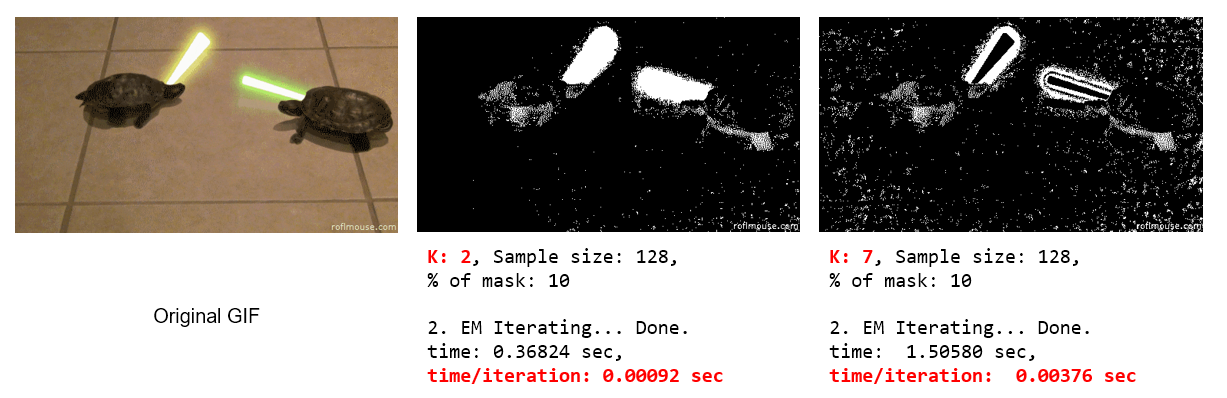

다음으로 E step과 M step에서 사용하는 <font color="#6464FF">표본 색의 수</font>에 따라 결과가 어떻게 달라지는지 살펴봅시다.

Next, let's examine how the results are affected by the number of <font color="#6464FF">sample colors</font> used in the E step and M step.

다음 두 결과는 영상 'penguin.gif'에서, 다른 설정은 같게 하고 표본의 수를 2, 32, 8192로 다르게 설정한 결과입니다.

The following results are from the "penguin.gif" image, with all other settings being the same, but with different numbers of samples: 2, 32, and 8192.

 <font color="#6464FF">표본의 수가 2</font>로 너무 적을 때는 학습의 손실 함수인 NLL의 값이 감소하고 수렴하는 데 실패하여 <font color="#6464FF">학습이 전혀 이루어지지 않았음</font>을 볼 수 있습니다. <font color="#6464FF">표본의 수가 32</font>일 때는 <font color="#6464FF">펭귄을 전경으로 잘 분류</font>하지만, <font color="#6464FF">사진 중간에 보이는 파란색의 물을 전경으로 잘못 분류</font>한 것을 볼 수 있습니다. <font color="#6464FF">표본의 수가 8192</font>일 때는 <font color="#6464FF">펭귄을 전경으로 잘 분류하고 사진 중간에 보이는 물 역시 배경으로 잘 분류</font>하고 있습니다. E step과 M step을 1회씩 진행하는 데 걸린 시간은 표본의 크기가 클수록 길어졌습니다.

When the number of samples is <font color="#6464FF">too low (2)</font>, we can see that the value of the negative log-likelihood (NLL) loss function decreases but <font color="#6464FF">fails to converge</font>, indicating that no effective learning has taken place. <font color="#6464FF">With 32 samples</font>, the algorithm appears to classify the penguin as the <font color="#6464FF">foreground correctly</font>. However, it <font color="#6464FF">incorrectly classifies the blue water</font> in the middle of the image as foreground.
<font color="#6464FF">With 8192 samples</font>, the algorithm <font color="#6464FF">successfully classifies</font> the penguin as the foreground and accurately classifies the water in the middle of the image as the background. The execution time for one iteration of the E step and M step increases as the number of samples grows larger.

<font color="#6464FF">표본의 수가 적으면 손실 함수가 수렴하지 않아 배경/전경 분류가 일어나지 않거나, 상대적으로 작은 배경의 경우 학습에 사용되지 않아 전경으로 잘못 분류되는 경우가 생기며, 표본의 수가 크면 정확도가 높아지지만 실행 시간이 길어지는 것</font>을 확인할 수 있습니다.


<font color="#6464FF">When the number of samples is small, the loss function may not converge, leading to a failure in background/foreground classification</font>. Additionally, in cases where the background is relatively small, it may not be adequately represented in the training, resulting in misclassification as foreground. On the other hand, <font color="#6464FF">as the number of samples increases, the accuracy improves, but the execution time also becomes longer</font>.



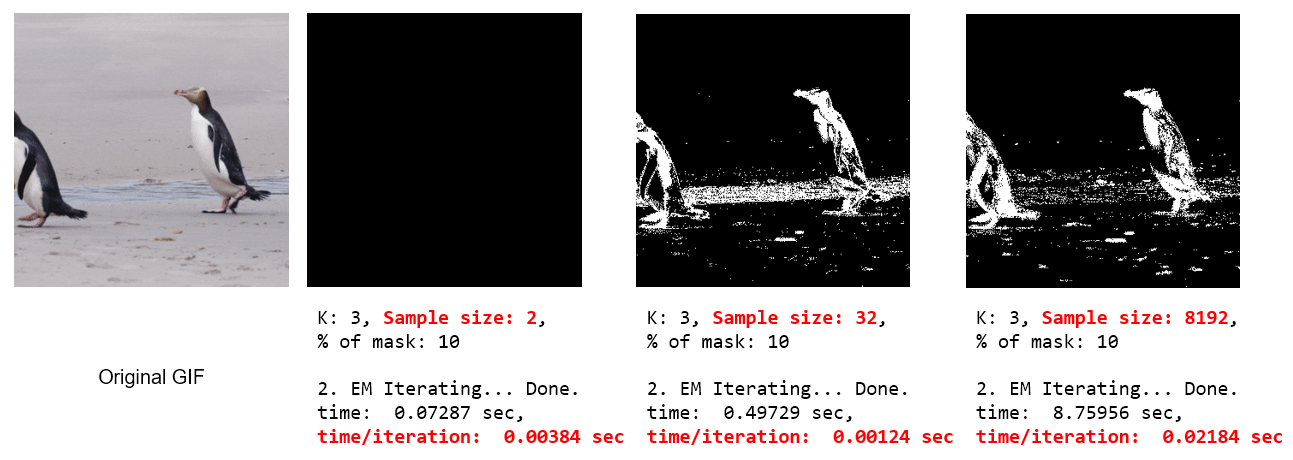

마지막으로, <font color="#6464FF">전경 마스크의 비율</font>에 따라 결과가 어떻게 달라지는지 살펴봅시다.


Let's examine how the results vary based on <font color="6464FF">the proportion of the foreground mask</font>.

다음 3개의 결과는 원본 영상에 같은 설정으로 EM 알고리즘을 적용한 후, 전경 마스크의 비율을 다르게 설정한 결과입니다.


The following three results are obtained by applying the EM algorithm to the original video with the same settings, but with different proportions of the foreground mask.

10%의 픽셀을 전경으로 분류한 경우, 영상에 등장하는 거북이가 배경으로 잘못 분류되었습니다.<br>
30%의 픽셀을 전경으로 분류한 경우, 거북이와 광선검 모두 전경으로 잘 분류되었지만 바닥 타일의 선이 전경으로 잘못 분류되었습니다.<br> 70%의 픽셀을 전경으로 분류한 경우 거북이와 광선검 모두 전경으로 분류되었지만, 배경의 상당 부분도 전경으로 분류되는 것을 볼 수 있습니다.


In the first case, where 10% of the pixels are classified as foreground, the turtle in the video is incorrectly classified as background.<br>In the second case, where 30% of the pixels are classified as foreground, both the turtle and the lightsaber are correctly classified as foreground, but some parts of the floor tiles are mistakenly classified as foreground.<br>In the third case, where 70% of the pixels are classified as foreground, both the turtle and the lightsaber are correctly classified as foreground, but a significant portion of the background is also classified as foreground.

따라서, <font color="#6464FF">전경 마스크의 비율이 낮으면 전경을 배경으로 잘못 분류할 가능성이 높아지고, 높으면 배경을 전경으로 잘못 분류할 가능성이 높아진다</font>고 볼 수 있습니다.


Therefore, we can observe that <font color="#6464FF">when the foreground mask ratio is low, there is a higher possibility of misclassifying the foreground as background. Conversely, when the foreground mask ratio is high, there is a higher possibility of misclassifying the background as foreground</font>.

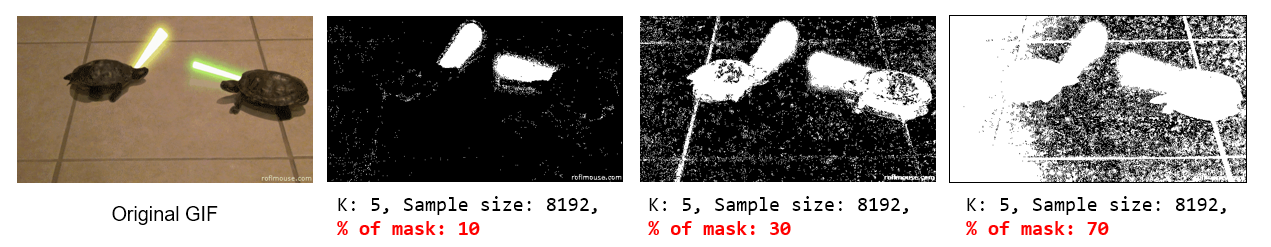

### Limitations

이 보고서에 사용된 GMM 모델과 알고리즘을 통해 배경 제거를 구현하면, 배경 제거의 결과가 $K$, 표본 픽셀의 크기, 전경 마스크 비율 등에 따라 크게 달라지기도 하고 어떤 영상에 대해서는 배경 제거가 잘 되지 않는 문제점이 발생합니다.


Indeed, the results of background removal using the GMM model and algorithm presented in this report can vary significantly depending on factors such as the value of K, the size of the sample pixels, and the foreground mask ratio. It is important to note that there may be limitations and challenges in achieving optimal background removal for certain videos.

다음은 Playground에 있는 두 파일인 "penguin.gif"와 "turtle.gif"에 대하여, 전경 마스크의 비율을 다르게 설정하여 배경 제거를 실행한 결과입니다.

The following are the results of running background removal on the two files "penguin.gif" and "turtle.gif" in the Playground, with different foreground mask ratios.

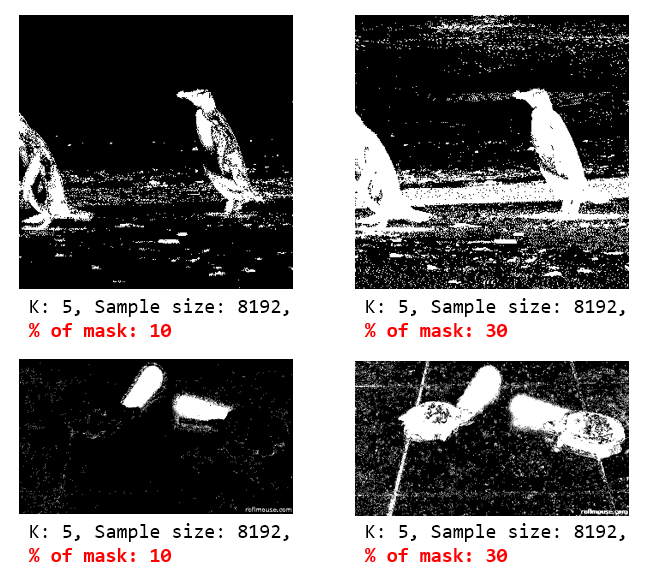

전경에 해당하는 펭귄 혹은 거북이를 잘 분류했는지, 또 배경에 해당하는 픽셀을 전경으로 분류하지는 않았는지를 토대로 결과를 분석하면, "penguins.gif"는 약 10%의 픽셀을 전경으로 분류했을 때, "turtle.gif"는 약 30%의 픽셀을 전경으로 분류했을 때 가장 합리적인 결과를 얻을 수 있었습니다.

Analyzing the results based on how well the penguins or turtles, which represent the foreground, are classified and whether any background pixels are misclassified as foreground, it can be observed that the most reasonable results were obtained when approximately 10% of the pixels were classified as foreground for "penguin.gif" and around 30% of the pixels were classified as foreground for "turtle.gif".

또한, 설정 값에 관계없이 분류가 잘 이루어지지 않는 영상도 존재합니다. Playground의 "parrot.gif" 영상에서는 CCTV 영상에 등장하는 앵무새가 전경으로 분류되어야 하지만 전경 마스크의 비율을 높이더라도 부리 부분이 제대로 분류되지 않는 것을 확인할 수 있습니다.

Furthermore, there are also cases where the classification does not work well regardless of the settings. In the "parrot.gif" video from the Playground, for example, the parrot appearing in the CCTV footage should be classified as foreground, but even with a higher foreground mask ratio, it can be observed that the beak area is not properly classified.

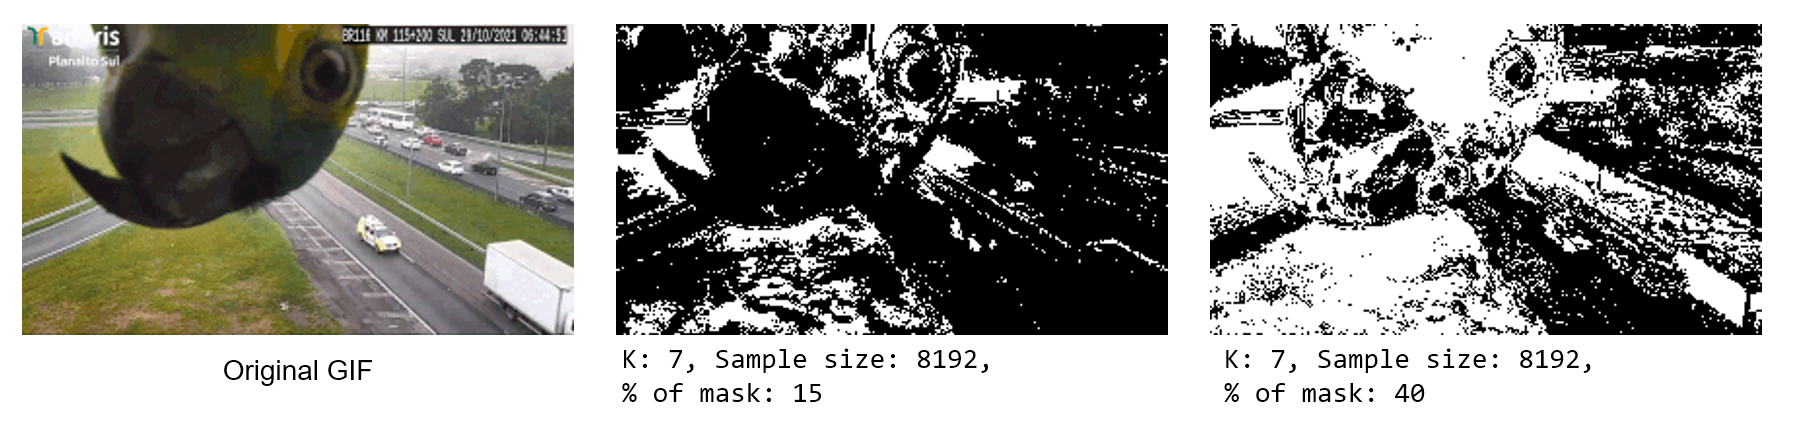

이러한 문제들이 발생하는 가장 큰 이유는, 현재의 알고리즘은 영상 전체의 색 정보를 이용하여 학습하는데, <font color="#6464FF">전경 픽셀이 영상의 상당 부분을 차지하여 GMM 모델의 가정인 "전경 픽셀이 배경 픽셀보다 현저히 낮은 Likelihood를 갖는다"가 성립하지 않기 때문</font>입니다.

The main reason for these issues is that the current algorithm learns based on the color information of the entire image, and it does not hold true to the assumption of the GMM model that "foreground pixels have significantly lower likelihood than background pixels." <font color="#6464FF">This is because foreground pixels occupy a substantial portion of the image.</font>

<font color="#6464FF">만약 전경에 해당하는 대상이 영상의 처음 부분부터 등장하여 오랜 시간 동안 화면에 머무르거나, 크기가 커서 화면의 많은 부분을 차지하는 경우</font>, 전경으로 분류되어야 할 픽셀의 빈도가 일부 배경 픽셀의 빈도보다 높아질 수 있게 됩니다. 예를 들어, "turtle.gif"과 같은 영상에서는 전경인 거북이(아래 그림의 빨간색)와 배경인 바닥 타일 줄무늬(아래 그림의 노란색) 모두 영상에 계속 등장하지만, 바닥 타일 줄무늬 색을 나타내는 픽셀이 적기 때문에 이 알고리즘은 바닥 타일 줄무늬보다 거북이를 배경이라고 인식할 수도 있게 됩니다.


<font color="#6464FF">If the foreground object appears from the beginning of the video and stays on the screen for a long time or if it is large enough to occupy a significant portion of the screen, the frequency of pixels that should be classified as foreground may become higher than the frequency of some background pixels</font>. For example, in a video like "turtle.gif," both the foreground object (the red part in the image below) and the background pattern of the floor tiles (the yellow part in the image below) appear continuously. However, since the number of pixels representing the floor tile pattern is small, this algorithm may mistakenly classify the turtle as background instead of foreground.

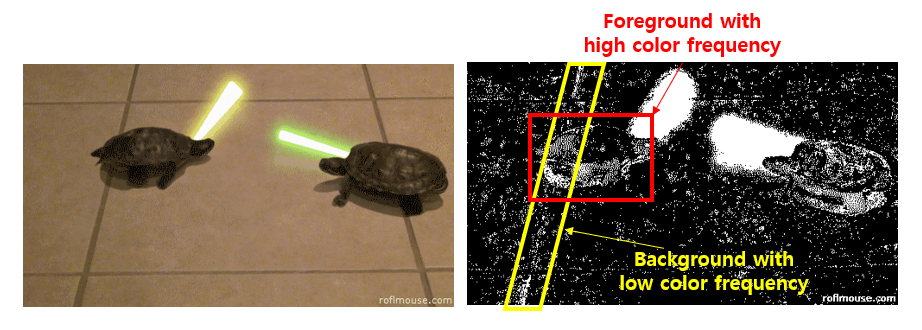

따라서, <font color="#6464FF">이 알고리즘이 잘 작동하기 위한 영상의 조건으로는 GMM 모델의 학습에 이용되는 색 중, 배경 픽셀이 전경 픽셀에 비해 나타나는 빈도가 커야 한다</font>는 것을 알 수 있습니다.

Therefore, a key condition for this algorithm to work well is that the frequency of background pixels is <font color="#6464FF">significantly higher than the frequency of foreground pixels among the colors used for training the GMM model</font>.

Playground의 파일 중 "duck.gif", "girmy.gif", "seal.gif"는, 영상의 첫 절반 부분이 배경을 비추고 있고 전경에 해당하는 대상이 잠깐 나타났다가 사라집니다. 이러한 경우, 전경 마스크의 비율을 낮게 설정한 뒤 알고리즘을 실행하면 배경과 전경을 보다 잘 구분할 수 있는 것을 확인할 수 있습니다.

Among the files in Playground, "duck.gif," "girmy.gif," and "seal.gif" have the first half of the video showing the background while the foreground objects briefly appear and then disappear. In such cases, when the foreground mask ratio is set to a lower value and the algorithm is executed, it is observed that the background and foreground can be better distinguished.

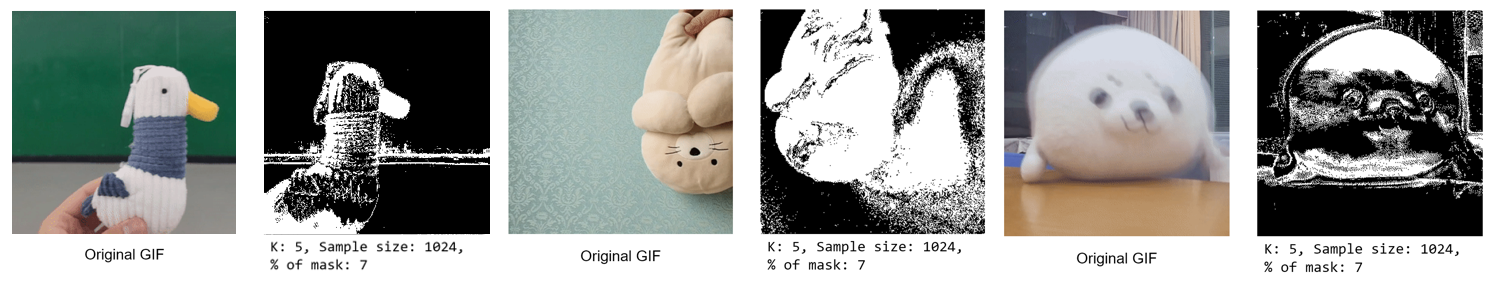

## Conclusion

이 보고서에서는 객체 인식 혹은 추적 기술의 전처리 과정으로 사용되는, 배경 제거 알고리즘에 대해 알아보고, 영상에 등장하는 <font color="6464FF">배경을 GMM으로 모델링</font>한 뒤 <font color="6464FF">EM 알고리즘을 통해 모수를 학습</font>시켰습니다. 그리고 특정 프레임의 특정 픽셀이 갖는 GMM PDF 값이 특정 값보다 낮다면 픽셀을 전경으로, 높다면 배경으로 분류하는 방법을 통해 실제 영상의 배경을 제거한 <font color="6464FF">전경 마스크를 획득</font>하였습니다. 또한, 학습 및 영상 처리에 사용되는 각종 변수의 값을 바꾸어 봄으로써 배경 제거가 원활하게 이루어지는지도 확인하였고 이 알고리즘의 <font color="6464FF">한계점 및 원인, 해결책</font> 등에 대해서도 이야기했습니다.

In this report, we explored background removal algorithms that are used as preprocessing steps for object recognition or tracking. We <font color="6464FF">modeled the background in the video using a Gaussian Mixture Model (GMM)</font> and <font color="6464FF">trained its parameters using the Expectation-Maximization (EM) algorithm</font>. We obtained <font color="6464FF">foreground masks</font> by classifying pixels as foreground or background based on whether the GMM PDF value of a specific pixel in a specific frame is lower or higher than a certain threshold value. By applying this approach, we removed the background from the actual video and obtained foreground masks. We experimented with various values of the variables used in training. Also, we explored <font color="6464FF">limitations, some cases when this algorithm does not work well, causes of the issue and possible solutions</font>.


보고서에서는 간단하게 영상을 다운로드하고 학습하기 위해 100개 이하의 프레임으로 이루어진 짧은 길이의 GIF 파일을 영상으로 활용하였지만, <font color="#6464FF">실제로 고정된 위치의 카메라가 좀 더 오랫동안 배경 프레임을 학습한다면 전경 프레임의 색이 나타나는 빈도는 이 보고서에서보다 훨씬 작을 것으로 기대할 수 있으므로, 좀 더 정확하게 전경과 배경을 분리할 수 있을 것</font>입니다.

We used short GIF files with fewer than 100 frames for the purpose of simplicity in downloading and training the algorithm. However, <font color="#6464FF">in a real-world scenario where a fixed-position camera observes the background frames for a longer duration, we can expect the frequency of foreground frame colors to be much lower than what was observed in this report. Consequently, we can anticipate achieving more accurate separation of foreground and background </font>by incorporating a longer and more representative sample of background frames into the training process.

## References

[1] Marc Peter Deisenroth A. Aldo Faisal Cheng Soon Ong, Feb 15, 2023., _Mathmatics for Machine Learning_., https://mml-book.com.
<br>
[2] Stauffer, C., Grimson, W. E. L. _Adaptive background mixture models for real-time tracking. in Proceedings_, 1999. IEEE Computer Society Conference on Computer Vision and Pattern Recognition. IEEE Computer. Soc. Part Vol. 2, 1999.
<br>
[3] Azad Soni, Dec 6, 2017., _Clustering with Gaussian Mixture Model_., Accessed in May 28, 2023.,
https://medium.com/clustering-with-gaussian-mixture-model/clustering-with-gaussian-mixture-model-c695b6cd60da.
<br>
[4] First Principles of Computer Vision, 2021., _Gaussian Mixture Model | Object Tracking_., Accessed in May 28, 2023.,
https://www.youtube.com/watch?v=0nz8JMyFF14.
<br>
[5] Prantik, May 24, 2020., _Background Extraction from videos using Gaussian Mixture Models_., Accessed in May 28, 2023.,
https://medium.com/@prantiksen4/background-extraction-from-videos-using-gaussian-mixture-models-6e11d743f932.
<br>
[6] Wikipedia, n.d., _Expectation-maximization algorithm_., Accessed in May 29, 2023., https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm.
<br>
[7] BBC, Nov 2, 2021., _Brazil: Amazon parrot plays peekaboo with CCTV traffic camera_., Accessed in June 7, 2023., https://www.bbc.com/news/av/world-latin-america-59136233.
<br>